In [137]:
#IMPORTS
%run ../datuslib.ipynb

In [60]:
#SETTINGS
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
#CARGA DATA

A_tweets = pd.read_csv(generateAbsolutePath("train.csv", exists = True))

In [4]:
#CARGA DE INTERNET PALBRAS NEGATIVAS

A_NEGATIVE_WORDS = getWordInListFromFile('negativeWords.txt')

# SE PLANTEA UN ANALISIS DE LA NEGATIVIDAD DE LOS TWEETS Y SU RELACION CON SI SON DESASTRES O NO

    Para esto se recurre a un analisis de frecuencias por palabras dependiendo de si es desastre o no y su relacion con las otras palabras. 
    
    Con esto lo que se quiere decir es que por la semantica misma, la palabra 'terremoto' es probable que sea usada seguido en desastres y poco en no desastres por lo que P(terremoto) seria una buena medida de negatividad
    
    En la misma linea, la palabra 'japon' quizas no sea semanticamente negativa pero tiene una alta probabilidad de ser negativa si en el mismo tweet figura 'terremoto' por lo que se puede definir negatividad contextual de japon con respecto a terremoto como P(japon | terremoto)P(terremto)
    
    Aplicando a cada tweet la suma de negatividades intrinsecas y contextuales se le asigna un numero que es la negatividad de ese tweet
    
    Para hacer un analisis con la intencion de que se comprenda la escencia de las palabras y no su escritura se lleva a cabo un preprocesamiento de las mismas
    
    Todo esto es provisto por la clase Context

In [159]:
#CREO EL OBJETO CONTEXT QUE CONTIENE TODA LA INFORMACION ESTADISTICA DE LAS INTERCONEXIONES DE PALABRAS EN TWEETS
context = Context(data = A_tweets)

Data loaded
Extracted texts
Extracted Texts Tokens
Tokens processed into cleaned up words and mapped
Contextual map produced
Total and Disaster frequencies calculated for every word
Negativity map produced


In [102]:
#LO COMENTADO ES LO QUE SE USO PARA CALCULAR LA NEGATIVIDAD DE CADA TWEET EN TODO EL DATASET (35 mins aporx)

#A_tweets = A_tweets.copy().fillna(' ')
#A_tweets['negativity'] = A_tweets.apply(lambda row : getTweetNegativity(row,context), axis = 1)
#A_tweets.to_csv('tweets_con_negatividad.csv')

#SE CARGA EL DATASET PRE PROCESADO

A_tweets = pd.read_csv(generateAbsolutePath("tweets_con_negatividad.csv", exists = True))

# LA ECUACION MAS PELIGROSA DE LA HISTORIA

    Para no caer en el error de sacar conclusiones sobre caracteristicas de los datos sin tener en cuenta la cantidad de poseen esa caracteristica, se analiza la frecuencia de cada clase que forman los datos por sus diferentes niveles de negatividad y se truncan aquellos que no superan en frecuencia a la raiz cuadrada de la totalidad de los datos

In [124]:
truncatingValue = np.sqrt(A_tweets.groupby('negativity').count().shape[0])
print("RAIZ(N) = ",truncatingValue)

RAIZ(N) =  86.4291617453276


In [120]:
#BUSCANDO UNA CANTIDAD RAZONABLE SOBRE LA QUE DISCRETIZAR LOS DIFERENTES NIVELES DE NEGATIVIDAD

maxbins = A_tweets.groupby('negativity').count().shape[0]
print("maxbins: ",maxbins)

for bucketSize in range(1,11):
    A_tweets['coarse-grained negativity'] =  A_tweets.apply(lambda row : round(row['negativity']/bucketSize)*bucketSize, axis = 1)
    print("bucketSize: ",bucketSize,"bins: ",A_tweets.groupby('coarse-grained negativity').count().shape[0])

maxbins:  7470
bucketSize:  1 bins:  116
bucketSize:  2 bins:  65
bucketSize:  3 bins:  45
bucketSize:  4 bins:  35
bucketSize:  5 bins:  28
bucketSize:  6 bins:  24
bucketSize:  7 bins:  21
bucketSize:  8 bins:  19
bucketSize:  9 bins:  17
bucketSize:  10 bins:  15


In [121]:
#SE ELIGE EL bucketsize

bucketSize = 3
A_tweets['coarse-grained negativity'] =  A_tweets.apply(lambda row : round(row['negativity']/bucketSize)*bucketSize, axis = 1)

In [122]:
#SE CALCULA LA FRECUENCIA DE CADA CLASE DE NEGATIVIDAD

A_negativityFrec = A_tweets.copy()
A_negativityFrec['frecuency'] = 1
A_negativityFrec = A_negativityFrec.groupby('coarse-grained negativity').sum().reset_index()[['coarse-grained negativity','frecuency']]

# PLOT: Frecuencia en tweets de cada nivel de negatividad

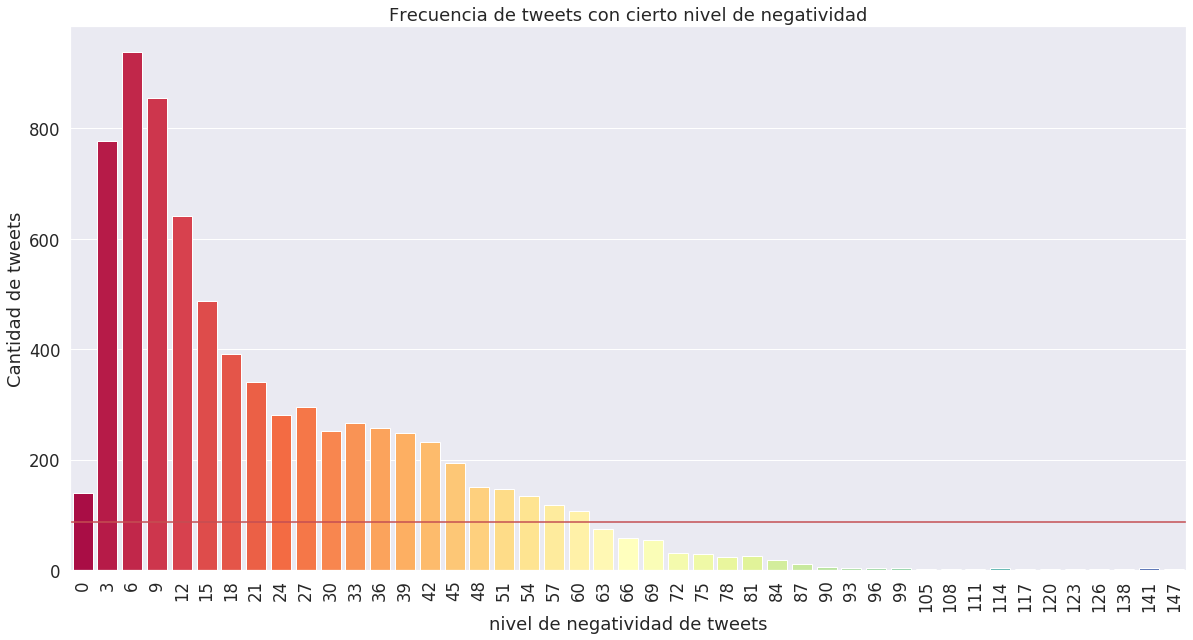

In [129]:
v = barplot(y = 'frecuency', x = 'coarse-grained negativity', data = A_negativityFrec, 
        xLabel = 'nivel de negatividad de tweets', yLabel = 'Cantidad de tweets',
        title = 'Frecuencia en tweets de cada nivel de negatividad', figY = 10, figX = 20,
        fontSize = 1.5, xrotate = 90)

v.axhline(truncatingValue, ls = '-', color = 'r')

# ANALISIS
    
    En el pltot se puede ver como la linea horizontal marca ese valor de raiz cuadrada de N y se ve como a partir de los tweets que tienen negatividad mayor a 60 tienen una frecuencia inferior a este valor.
    
    Visto esto se decide truncar todos los tweets cuyos valores de negatividad superen 60 para que las conclusiones estadisticas sobre los tweets resatantes sean razonable

In [131]:
#SE TRUNCAN LOS TWEETS CUYOS VALORES DE NEGATIVIDAD SUPERAN 60

truncatingValue = 60
A_tweetsTruncated = A_tweets[ A_tweets['coarse-grained negativity'] <= truncatingValue]

In [132]:
#SE CALCULA P(desastre | negatividad = n) (tarda 50mins)

A_label = 'conditional probability of disaster given negativity'
A_tweetsTruncated[A_label] = A_tweetsTruncated.apply(lambda row : probabilityOfGivenThat(isDisaster,
                                                                       lambda x : x['coarse-grained negativity'] == row['coarse-grained negativity'],
                                                                      A_tweetsTruncated), axis = 1)

#A_tweetsTruncated = A_tweetsTruncated.drop(columns = ['Unnamed: 0'])
#A_tweetsTruncated.to_csv('tweets_truncados_con_probabilidad_condicional_dada_una_negatividad.csv')

#SE CARGA EL DATASET PRE PROCESADO

#A_tweetsTruncated = pd.read_csv(generateAbsolutePath("tweets_truncados_con_probabilidad_condicional_dada_una_negatividad.csv", exists = True))

/home/axelmpm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# PLOT: P(desastre | nivel de negatividad = n)    para cada nivel de negatividad n

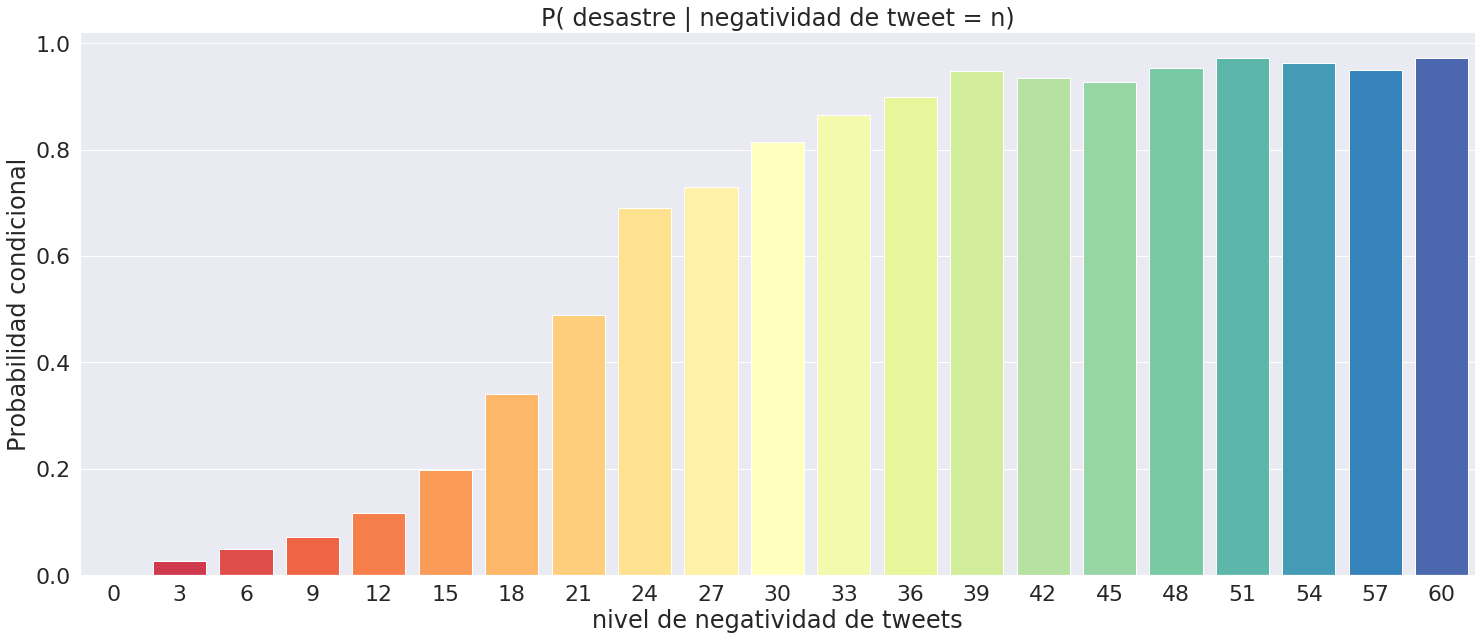

In [133]:
barplot(y = A_label, x = 'coarse-grained negativity', data = A_tweetsTruncated, xLabel = 'nivel de negatividad de tweets', yLabel = 'Probabilidad condicional',
        title = 'P( desastre | negatividad de tweet = n)', fontSize = 2)

# CONCLUSION
    
    Se puede ver que esta metrica artesanal de negatividad es monotona creicient con la 'desastrocidad' de los tweets, es decir, cuando mas alto da la negatividad, mas probable es que se trate de un desastre.
    
    Esto muestra que esta negatividad puede ser utilizada como indicador y potencialmente de predictor de desastre de un tweet basandose en su contenido
    
    Particularmente puede verse como a partir del nivel 20 de negatividad la probabilidad de desastre supera el 50% bruscamente. Uno podria clasificar un tweet como desastre o no desastre usando a este valor como medida

# PLOT: Palabras mas usadas

In [146]:
#CREANDO UN DATAFRAME DE SUSTANTIVOS/FRECUENCIAS

A_wordsDF = getDataFrameOfFrecuencies('Palabras',context.cleanWords)

A_TOP_AMOUNT = 15
A_topWords = A_wordsDF.head(A_TOP_AMOUNT)

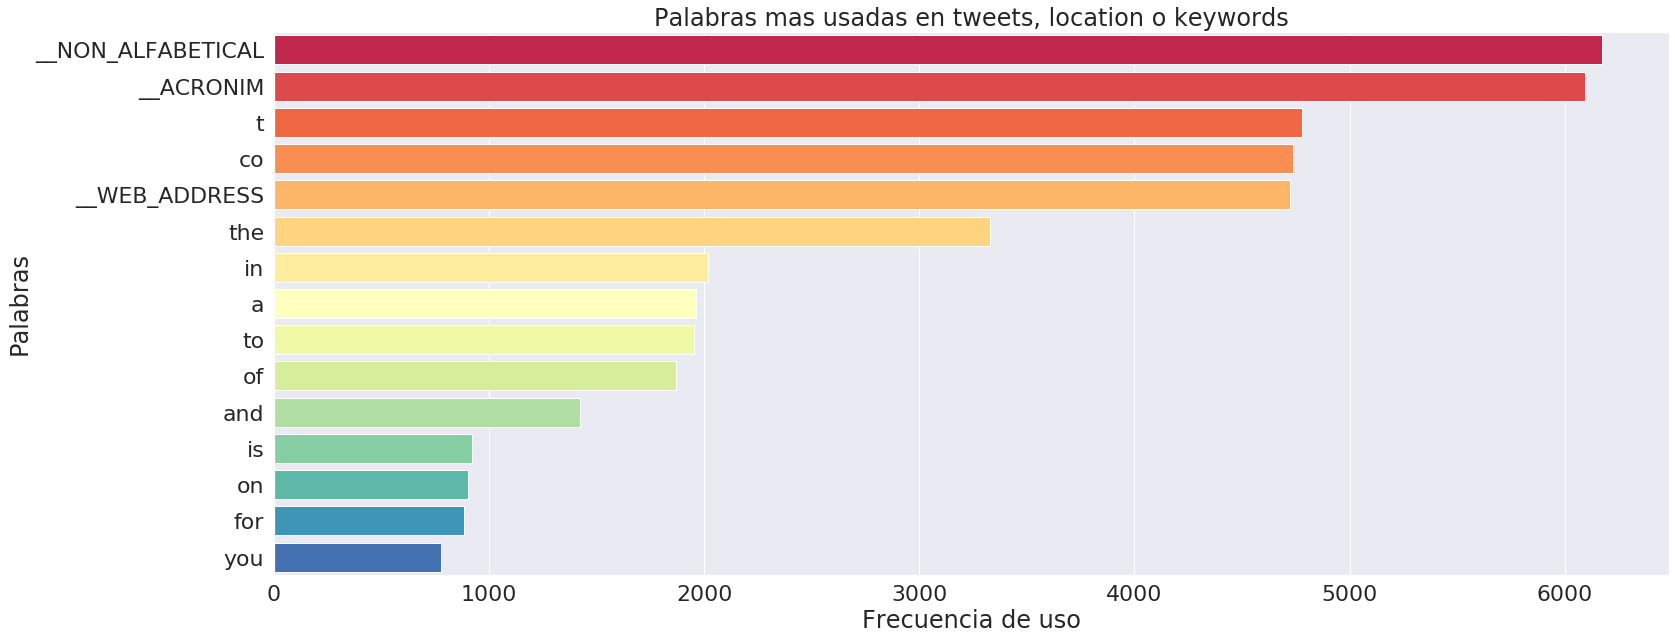

In [147]:
barplot('Cantidad','Palabras', A_topWords, xLabel = 'Frecuencia de uso', yLabel = 'Palabras',
        title = 'Palabras mas usadas en tweets, location o keywords', fontSize = 2)

# PLOT: Palabras negativas mas usadas

    En este plot se esta usando como palabras negativas a plabras buscadas en internet

In [148]:
#CREANDO UN DATAFRAME DE SUSTANTIVOS NEGATIVOS/FRECUENCIAS

A_NegativeWordsDF = A_wordsDF[ A_wordsDF.apply(lambda row : isIn(row['Palabras'],A_NEGATIVE_WORDS), axis = 1)]

A_TOP_AMOUNT = 15
A_topNegativeWords = A_NegativeWordsDF.head(A_TOP_AMOUNT)

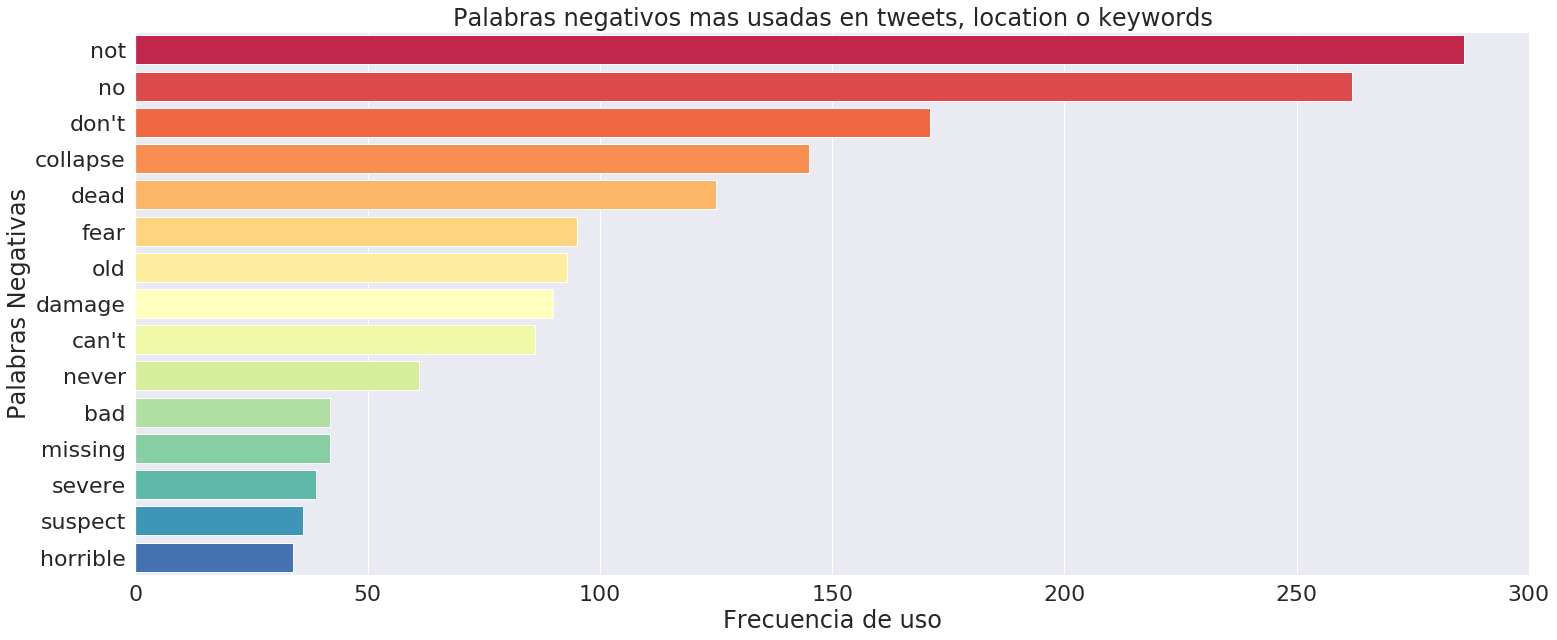

In [149]:
barplot('Cantidad','Palabras', A_topNegativeWords, xLabel = 'Frecuencia de uso', yLabel = 'Palabras Negativas', 
        title = 'Palabras negativas mas usadas en tweets, location o keywords', fontSize = 2)

# PLOT: Palabras mas usados en tweets de desastres

    En este plot se esta usando como palabras negativas a plabras buscadas en internet

In [152]:
#OBTIENE TODAS LAS PALABRAS FIGURAN EN CAMPO TEXT, KEYWORD y LOCATION DET TWEETS CON DESASTRE

A_tweetsDisaster = A_tweets[A_tweets['target'] == 1]

A_wordsDisasters = dicToDataFrame(context.disasterCleanWordFrequency)
A_wordsDisasters['values'] = round(A_wordsDisasters['values'] * A_tweets.shape[0])

A_TOP_AMOUNT = 15
A_topDisasterWords = A_wordsDisasters.head(A_TOP_AMOUNT)

In [163]:
context.context

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 '__ACRONIM',
 'forgive',
 'us',
 'all',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask',
 'canada',
 'all',
 'residents',
 'asked',
 'to',
 "'shelter",
 'in',
 "place'",
 'are',
 'being',
 'notified',
 'by',
 'officers',
 'no',
 'other',
 'evacuation',
 'or',
 'shelter',
 'in',
 'place',
 'orders',
 'are',
 'expected',
 'people',
 'receive',
 'wildfires',
 'evacuation',
 'orders',
 'in',
 'california',
 'just',
 'got',
 'sent',
 'this',
 'photo',
 'from',
 'ruby',
 'alaska',
 'as',
 'smoke',
 'from',
 'wildfires',
 'pours',
 'into',
 'a',
 'school',
 'rockyfire',
 'update',
 'california',
 'hwy',
 'closed',
 'in',
 'both',
 'directions',
 'due',
 'to',
 'lake',
 'county',
 'fire',
 'cafire',
 'wildfires',
 'flood',
 'disaster',
 'heavy',
 'rain',
 'causes',
 'flash',
 'flooding',
 'of',
 'streets',
 'in',
 'manitou',
 'colorado',
 'springs',
 'areas',
 "i'm",
 'on',
 'top',
 'of',
 'the',
 'hill'

In [156]:
barplot('Keys','Values', A_topDisasterWords, xLabel = 'Frecuencia de uso', yLabel = 'Palabras', 
        title = 'Palabras mas usadas en tweets de desastres, location o keywords', fontSize = 2)

ValueError: Could not interpret input 'Keys'

# PLOT: Relacionando negatividad de los tweets y su longitud con si son desastres o no

In [16]:
#MOLDEANDO DATA
A_tweets1 = A_tweets.copy()

#(AGREGA) CAMPO DE TARGET CON NOMBRES MAS DETALLADOS QUE 1 o 0
A_tweets1['Categoria'] = A_tweets1.apply(lambda row : mapBinaryLabel(row['target'],
                                                                            ['Desastre','No Desastre']), axis = 1)
#(AGREGA) CAMPO DE LONGITUD DE TWEETS
A_tweets1['length'] = A_tweets1.apply(lambda row : len(row['text']), axis = 1)

#(AGREGA) CAMPO DE PALABRAS NEGATIVAS
A_tweets1['usa palabras negativas'] = A_tweets1.apply(lambda row : mapBinaryLabel(hasCertainWords(row['text'],A_NEGATIVE_WORDS),['Usa Palabras Negativas','No Usa Palabras Negativas']), axis = 1)


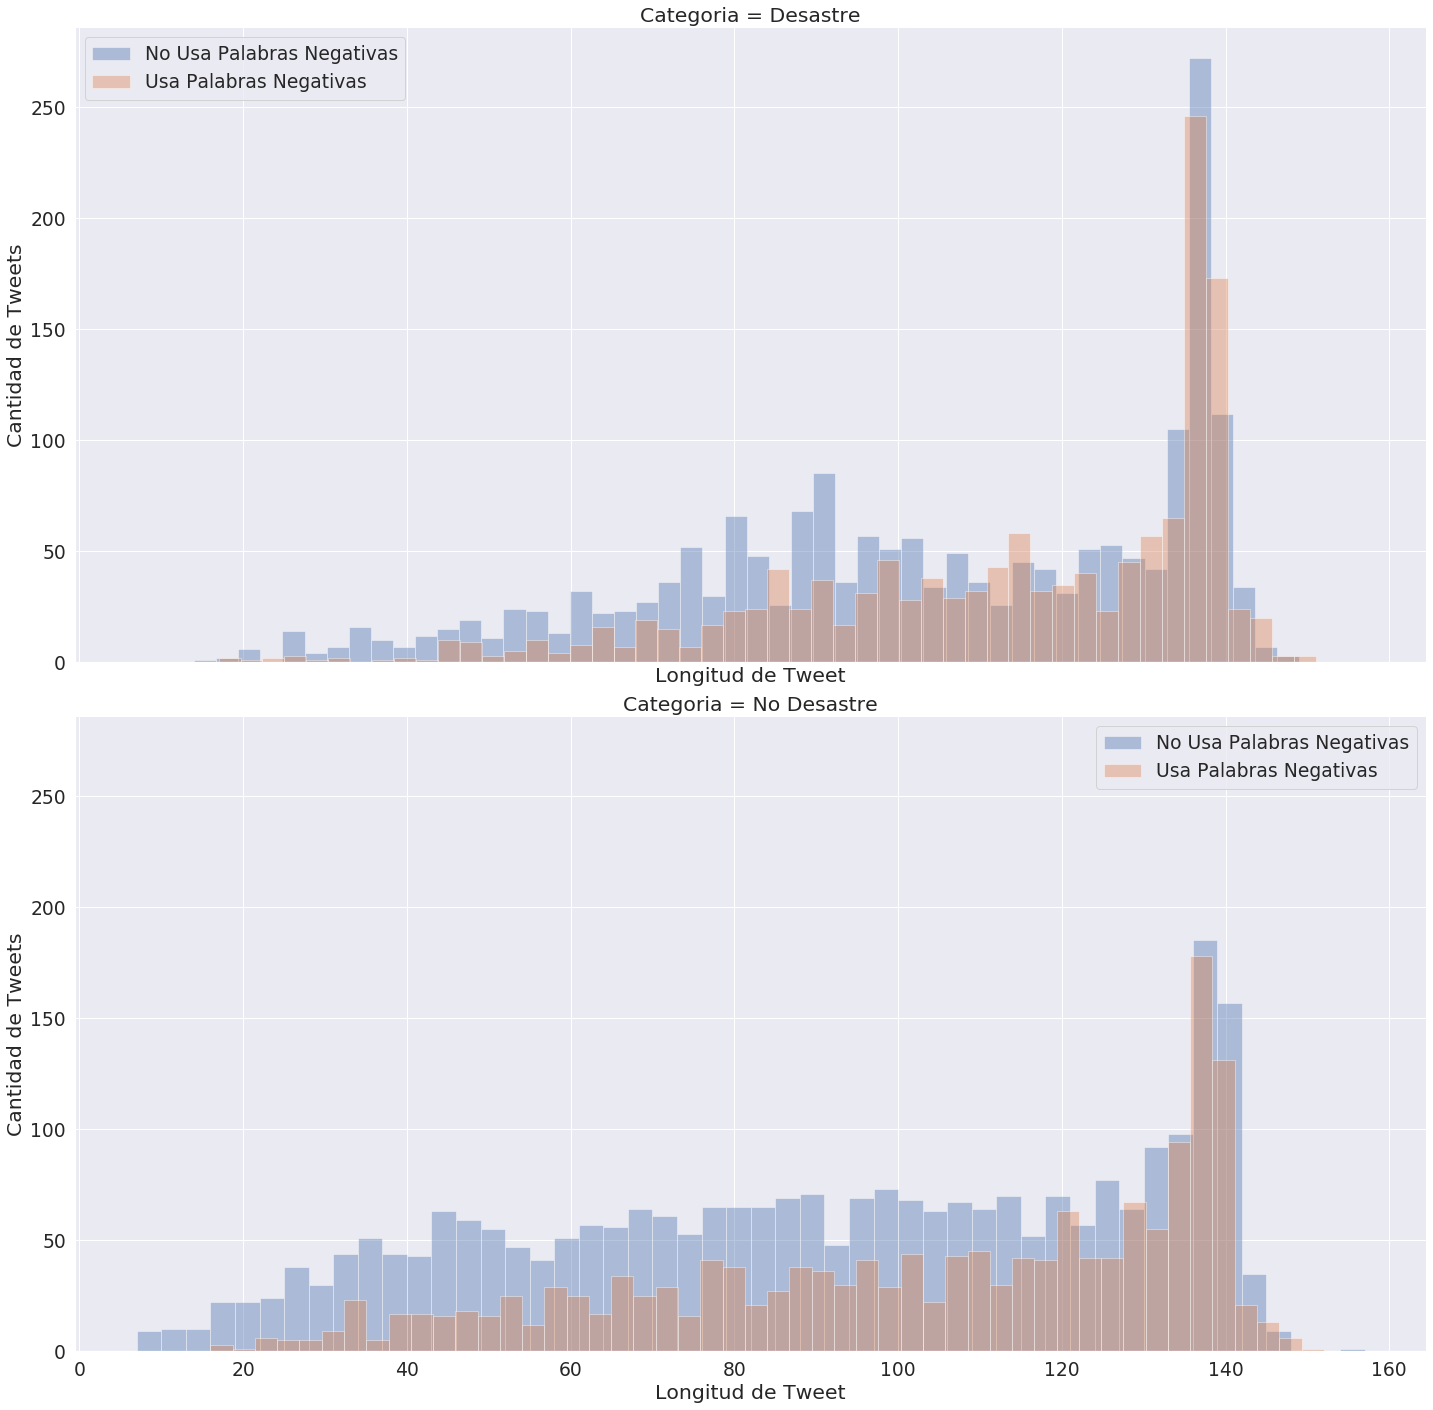

In [17]:
sns.set(font_scale = 1.7)
fg1 = sns.FacetGrid(A_tweets1, hue = 'usa palabras negativas',row = 'Categoria', height = 10, aspect = 2)
v = fg1.map(sns.distplot, "length", kde = False, bins = 50 )


for ax in v.axes.ravel():
    ax.legend()
    ax.set(xlabel = 'Longitud de Tweet', ylabel = 'Cantidad de Tweets')


# Analisis: 

Parece que en el caso de los desastres no parece haber diferencia en los tweets en cuanto a si usa o no palabras negativas (salvo en aquellos de longitud media que parecen tener un pequeña tendencia a ser mas neutros que negativos)

Por otro lado, en el caso de los no desastres, es claro que predominan en cualquier longitud de tweet (salvo en los largos) los tweets neutros







# FEATURE: Agregando escala de negatividad de un tweet (0 es nada y 1 es pura)